# Train, Deploy and Test a Machine Learning Model with SageMaker

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [60]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import os
import boto3
import sagemaker
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerRule,
    rule_configs,
    ProfilerConfig,
    FrameworkProfile,
)
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor
import matplotlib.pyplot as plt
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from mpl_toolkits.axes_grid1 import host_subplot

import requests
from PIL import Image
import torchvision.transforms as T
import io
import IPython

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [2]:
!unzip ./data/dogImages.zip -d ./data

Archive:  ./data/dogImages.zip
   creating: ./data/dogImages/
   creating: ./data/dogImages/test/
   creating: ./data/dogImages/train/
   creating: ./data/dogImages/valid/
   creating: ./data/dogImages/test/001.Affenpinscher/
  inflating: ./data/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: ./data/dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: ./data/dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: ./data/dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg  
  inflating: ./data/dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg  
  inflating: ./data/dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg  
  inflating: ./data/dogImages/test/001.Affenpinscher/Affenpinscher_00071.jpg  
  inflating: ./data/dogImages/test/001.Affenpinscher/Affenpinscher_00078.jpg  
   creating: ./data/dogImages/test/002.Afghan_hound/
  inflating: ./data/dogImages/test/002.Afghan_hound/Afghan_hound_00116.jpg  
  inflating:

In [3]:
boto_session = boto3.Session(profile_name="udacity-mle")
sagemaker_session = sagemaker.Session(boto_session=boto_session)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/alejlatorre/.config/sagemaker/config.yaml


In [4]:
iam_client = boto_session.client("iam")
response = iam_client.list_roles()

In [5]:
for role in response["Roles"]:
    print(role)

{'Path': '/service-role/', 'RoleName': 'AmazonSageMaker-ExecutionRole-20211211T184976', 'RoleId': 'AROAQ5G2LJN54ZDSUBTNO', 'Arn': 'arn:aws:iam::062734945147:role/service-role/AmazonSageMaker-ExecutionRole-20211211T184976', 'CreateDate': datetime.datetime(2021, 12, 11, 23, 49, 11, tzinfo=tzutc()), 'AssumeRolePolicyDocument': {'Version': '2012-10-17', 'Statement': [{'Effect': 'Allow', 'Principal': {'Service': 'sagemaker.amazonaws.com'}, 'Action': 'sts:AssumeRole'}]}, 'Description': 'SageMaker execution role created from the SageMaker AWS Management Console.', 'MaxSessionDuration': 3600}
{'Path': '/', 'RoleName': 'aws-sagemaker-execution-role', 'RoleId': 'AROAQ5G2LJN5RZFEVMYDP', 'Arn': 'arn:aws:iam::062734945147:role/aws-sagemaker-execution-role', 'CreateDate': datetime.datetime(2023, 11, 9, 5, 33, 16, tzinfo=tzutc()), 'AssumeRolePolicyDocument': {'Version': '2012-10-17', 'Statement': [{'Sid': '', 'Effect': 'Allow', 'Principal': {'Service': 'sagemaker.amazonaws.com'}, 'Action': 'sts:Assum

In [6]:
role = "arn:aws:iam::062734945147:role/aws-sagemaker-execution-role"
region = sagemaker_session.boto_region_name
bucket = sagemaker_session.default_bucket()
print(f"Default S3 bucket: {bucket}")
print(f"AWS Region: {region}")
print(f"Role Arn: {role}")

Default S3 bucket: sagemaker-us-east-1-062734945147
AWS Region: us-east-1
Role Arn: arn:aws:iam::062734945147:role/aws-sagemaker-execution-role


In [ ]:
prefix = "image-classification"
local_path = "data/dogImages/"

data = sagemaker_session.upload_data(path=local_path, bucket=bucket, key_prefix=prefix)

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [60]:
# TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128]),
    "epochs": CategoricalParameter([1, 2]),
}

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [98]:
# TODO: Create estimators for your HPs
estimator = PyTorch(
    entry_point="scripts/hpo.py",
    role=role,
    py_version="py36",
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large",
    sagemaker_session=sagemaker_session,
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [99]:
os.environ["SM_CHANNEL_TRAINING"] = f"s3://{bucket}/{prefix}/"
os.environ["SM_MODEL_DIR"] = f"s3://{bucket}/{prefix}/model/"

In [ ]:
# TODO: Fit your HP Tuner
tuner.fit({"training": data}, wait=True)  # TODO: Remember to include your data channels

In [95]:
# Get the best estimators and the best HPs
tuner_best_training_job = tuner.best_training_job()
best_estimator = tuner.best_estimator()

# Get the hyperparameters of the best trained model
best_estimator_hyperparameters = best_estimator.hyperparameters()


2023-11-09 06:17:29 Starting - Preparing the instances for training
2023-11-09 06:17:29 Downloading - Downloading input data
2023-11-09 06:17:29 Training - Training image download completed. Training in progress.
2023-11-09 06:17:29 Uploading - Uploading generated training model
2023-11-09 06:17:29 Completed - Resource reused by training job: pytorch-training-231109-0105-004-f1c8744f


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [102]:
# TODO: Set up debugging and profiling rules and hooks
hyperparameters = {
    "batch-size": best_estimator_hyperparameters["batch-size"].strip('"'),
    "lr": best_estimator_hyperparameters["lr"],
    "epochs": best_estimator_hyperparameters["epochs"].strip('"'),
}

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile()
)

collection_configs = [
    CollectionConfig(
        name="weights",
        parameters={"train.save_interval": "5", "eval.save_interval": "1"},
    ),
    CollectionConfig(
        name="gradients",
        parameters={"train.save_interval": "5", "eval.save_interval": "1"},
    ),
    CollectionConfig(
        name="biases",
        parameters={"train.save_interval": "5", "eval.save_interval": "1"},
    ),
    CollectionConfig(
        name="CrossEntopyLoss_output_0",
        parameters={
            "include_regex": "CrossEntropyLoss_output_0",
            "train.save_interval": "1",
            "eval.save_interval": "1",
        },
    ),
]

debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "5", "eval.save_interval": "1"},
    collection_configs=collection_configs,
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [103]:
# TODO: Create and fit an estimator
estimator = PyTorch(
    entry_point="scripts/train_model.py",
    base_job_name="Image-classification-Project-debugging",
    role=role,
    instance_count=1,
    instance_type="ml.c5.2xlarge",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    rules=rules,
    debugger_hook_config=debugger_config,
    profiler_config=profiler_config,
    sagemaker_session=sagemaker_session,
)

estimator.fit({"training": data}, wait=True)

Using provided s3_resource


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: Image-classification-Project-debugging-2023-11-09-06-39-25-386


2023-11-09 06:39:26 Starting - Starting the training job...
2023-11-09 06:39:52 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
ProfilerReport: InProgress
......
2023-11-09 06:40:52 Downloading - Downloading input data........bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-11-09 06:42:19,302 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-11-09 06:42:19,304 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-11-09 06:42:19,312 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-11-09 06:42:19,314 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-11-09 06:42:19,487 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-11-09 06:42:19,499 sagemaker-training-toolkit INFO     No GPUs detected (normal if no

In [104]:
job_name = estimator.latest_training_job.name
client = sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=job_name)

{'TrainingJobName': 'Image-classification-Project-debugging-2023-11-09-06-39-25-386', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:062734945147:training-job/Image-classification-Project-debugging-2023-11-09-06-39-25-386', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-062734945147/Image-classification-Project-debugging-2023-11-09-06-39-25-386/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch-size': '"128"', 'epochs': '"1"', 'lr': '"0.004934481307147922"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"Image-classification-Project-debugging-2023-11-09-06-39-25-386"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-062734945147/Image-classification-Project-debugging-2023-11-09-06-39-25-386/source/sourcedir.tar.gz"'}, 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.co

In [105]:
description

{'TrainingJobName': 'Image-classification-Project-debugging-2023-11-09-06-39-25-386',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:062734945147:training-job/Image-classification-Project-debugging-2023-11-09-06-39-25-386',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-062734945147/Image-classification-Project-debugging-2023-11-09-06-39-25-386/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'batch-size': '"128"',
  'epochs': '"1"',
  'lr': '"0.004934481307147922"',
  'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"Image-classification-Project-debugging-2023-11-09-06-39-25-386"',
  'sagemaker_program': '"train_model.py"',
  'sagemaker_region': '"us-east-1"',
  'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-062734945147/Image-classification-Project-debugging-2023-11-09-06-39-25-386/source/sourcedir.tar.gz"'},
 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us

In [108]:
with open("logs/training_job_description.txt", "w") as f:
    f.write(str(description))

In [129]:
!aws s3 cp s3://sagemaker-us-east-1-062734945147/Image-classification-Project-debugging-2023-11-09-06-39-25-386/debug-output models/debug-output --recursive --profile udacity-mle

download: s3://sagemaker-us-east-1-062734945147/Image-classification-Project-debugging-2023-11-09-06-39-25-386/debug-output/events/000000000001/000000000001_worker_0.tfevents to models/debug-output/events/000000000001/000000000001_worker_0.tfevents
download: s3://sagemaker-us-east-1-062734945147/Image-classification-Project-debugging-2023-11-09-06-39-25-386/debug-output/claim.smd to models/debug-output/claim.smd
download: s3://sagemaker-us-east-1-062734945147/Image-classification-Project-debugging-2023-11-09-06-39-25-386/debug-output/events/000000000002/000000000002_worker_0.tfevents to models/debug-output/events/000000000002/000000000002_worker_0.tfevents
download: s3://sagemaker-us-east-1-062734945147/Image-classification-Project-debugging-2023-11-09-06-39-25-386/debug-output/events/000000000003/000000000003_worker_0.tfevents to models/debug-output/events/000000000003/000000000003_worker_0.tfevents
download: s3://sagemaker-us-east-1-062734945147/Image-classification-Project-debugging

In [130]:
trial = create_trial(path="models/debug-output")

[2023-11-09 02:39:47.541 DESKTOP-P3SA3VT:25928 INFO local_trial.py:35] Loading trial debug-output at path models/debug-output


In [131]:
trial.tensor_names()

[2023-11-09 02:39:51.380 DESKTOP-P3SA3VT:25928 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-11-09 02:39:52.385 DESKTOP-P3SA3VT:25928 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'ResNet_bn1.bias',
 'ResNet_bn1.weight',
 'ResNet_conv1.weight',
 'ResNet_fc.0.bias',
 'ResNet_fc.0.weight',
 'ResNet_fc.2.bias',
 'ResNet_fc.2.weight',
 'ResNet_layer1.0.bn1.bias',
 'ResNet_layer1.0.bn1.weight',
 'ResNet_layer1.0.bn2.bias',
 'ResNet_layer1.0.bn2.weight',
 'ResNet_layer1.0.bn3.bias',
 'ResNet_layer1.0.bn3.weight',
 'ResNet_layer1.0.conv1.weight',
 'ResNet_layer1.0.conv2.weight',
 'ResNet_layer1.0.conv3.weight',
 'ResNet_layer1.0.downsample.0.weight',
 'ResNet_layer1.0.downsample.1.bias',
 'ResNet_layer1.0.downsample.1.weight',
 'ResNet_layer1.1.bn1.bias',
 'ResNet_layer1.1.bn1.weight',
 'ResNet_layer1.1.bn2.bias',
 'ResNet_layer1.1.bn2.weight',
 'ResNet_layer1.1.bn3.bias',
 'ResNet_layer1.1.bn3.weight',
 'ResNet_layer1.1.conv1.weight',
 'ResNet_layer1.1.conv2.weight',
 'ResNet_layer1.1.conv3.weight',
 'ResNet_layer1.2.bn1.bias',
 'ResNet_layer1.2.bn1.weight',
 'ResNet_layer1.2.bn2.bias',
 'ResNet_layer1.2.bn2.weight',
 'ResNet_layer1.2.bn

In [132]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for step in steps:
        vals.append(tensor.value(step, mode=mode))
    return steps, vals

In [133]:
# From exercises
def plot_tensor(trial, tensor_name):
    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)

    _ = plt.figure(figsize=(10, 7))
    host = host_subplot(111)
    par = host.twiny()
    host.set_xlabel("Steps - Train")
    par.set_xlabel("Steps - Eval")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

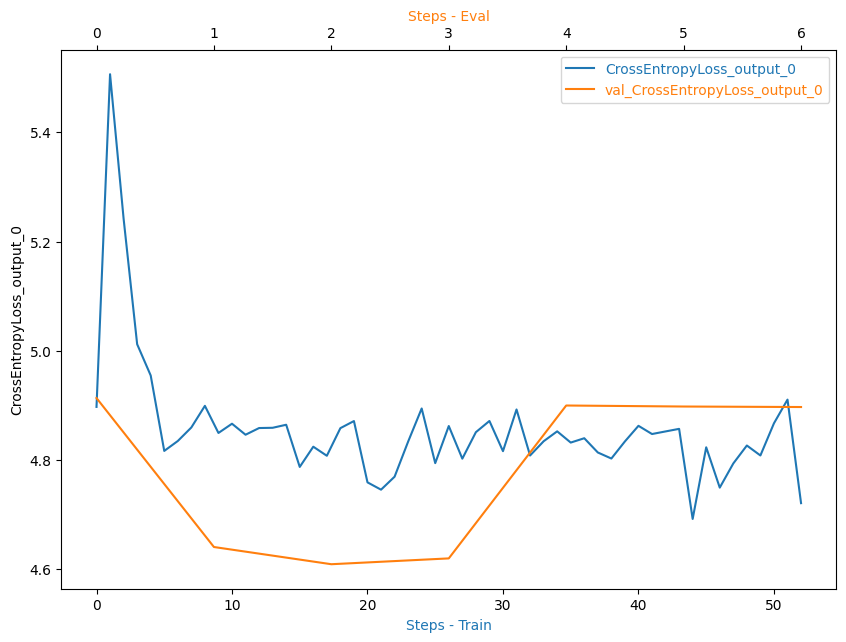

In [134]:
plot_tensor(trial=trial, tensor_name="CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

**Insights**
- The training loss decreases with the number of steps.
- From the fifth step onwards the cross entropy loss is noisy but keeps an average value of 4.8.
- The validation loss decreases up to the 27th step, then rises and keep constant. Before that is very low compared to the training loss (could be overfitting and then underfitting).

**Possible solutions**
- Test with a simpler model.
- Test with any regularization method to avoid overfitting.
- Test with more data.





In [138]:
!aws s3 cp s3://sagemaker-us-east-1-062734945147/Image-classification-Project-debugging-2023-11-09-06-39-25-386/rule-output models/rule-output --recursive --profile udacity-mle

download: s3://sagemaker-us-east-1-062734945147/Image-classification-Project-debugging-2023-11-09-06-39-25-386/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to models/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-062734945147/Image-classification-Project-debugging-2023-11-09-06-39-25-386/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to models/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-062734945147/Image-classification-Project-debugging-2023-11-09-06-39-25-386/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to models/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-062734945147/Image-classification-Project-debugging-2023-11-09-06-39-25-386/rule-output/ProfilerReport/pro

In [ ]:
# TODO: Display the profiler output
IPython.display.HTML(
    filename="models/rule-output/ProfilerReport/profiler-output/profiler-report.html"
)

## Model Deploying

In [46]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [50]:
model_path = "s3://sagemaker-us-east-1-062734945147/Image-classification-Project-debugging-2023-11-09-09-49-11-057/model.tar.gz"
pytorch_model = PyTorchModel(
    model_data=model_path,
    role=role,
    entry_point="scripts/inference.py",
    framework_version="1.8",
    py_version="py36",
    sagemaker_session=sagemaker_session,
    predictor_cls=ImagePredictor,
)

In [51]:
predictor = pytorch_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    endpoint_name="image-classification-endpoint",
)

-----!

In [52]:
request_dict = {
    "url": "https://sagemaker-us-east-1-062734945147.s3.amazonaws.com/image-classification/test/133.Yorkshire_terrier/Yorkshire_terrier_08325.jpg"
}

img_bytes = requests.get(request_dict["url"]).content
type(img_bytes)

bytes

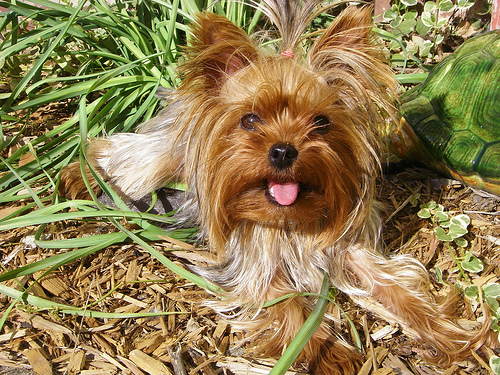

In [53]:
Image.open(io.BytesIO(img_bytes))

In [54]:
# TODO: Run an prediction on the endpoint
response = predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [59]:
response[0][:20]

[-11.818755149841309,
 -23.93946647644043,
 -16.528059005737305,
 -17.10870361328125,
 -17.838972091674805,
 -21.144777297973633,
 -12.256084442138672,
 -16.974124908447266,
 -14.588923454284668,
 -18.741077423095703,
 -21.963314056396484,
 -22.19807243347168,
 -18.557689666748047,
 -9.5072660446167,
 -22.067834854125977,
 -16.86520004272461,
 -18.757532119750977,
 -11.70285701751709,
 -17.927722930908203,
 -17.17595863342285]

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()